In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date, time, timedelta, datetime
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import Dataset
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
import gc 
from statistics import mean, median, stdev
import pickle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final.zip", index_col=0)

In [ ]:
new_df.drop(['public_date', 'start_price', 'end_price', 'TICKER', 'price_year_before', 'date_before_year', 'adate', 'qdate', 'permno', 'CUSIP'], axis=1).columns

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm',
       'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx',
       'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'PEG_1yrforward', 'PEG_ltgforward', 'cusip', 'growth',
       'momentum'],
      

In [ ]:
print(wrong, corr)
print(wrong+corr)

0 0
0


In [ ]:

# For mlp
class CompanyDatasetMLP(Dataset):
    """
    Custom torch dataset class for the annotated images

    """
    def __init__(self, df, evaluate=False):
        self.evaluate = evaluate
        self.features, self.growth = self.standardize(df)

    
    def standardize(self, df):
        if not self.evaluate:
          df_tmp = df.drop(['public_date', 'start_price', 'end_price', 'TICKER', 'price_year_before', 'date_before_year', 'adate', 'qdate', 'permno', 'CUSIP', 'cusip'], axis=1)

          growth = list(1+df_tmp['growth'])
          df_tmp = df_tmp.drop(['growth'], axis=1)
          scaler = StandardScaler()
          df_tmp = scaler.fit_transform(df_tmp)

          assert len(df_tmp) == len(growth)

          return df_tmp, growth
        else:
          df_tmp = df.drop(['public_date', 'start_price', 'end_price', 'TICKER', 'price_year_before', 'date_before_year', 'adate', 'qdate', 'permno', 'CUSIP', 'cusip'], axis=1)
          prices = df[['start_price', 'end_price']]

          growth = list(1+df_tmp['growth'])
          df_tmp = df_tmp.drop(['growth'], axis=1)
          scaler = StandardScaler()
          df_tmp = scaler.fit_transform(df_tmp)

          assert len(df_tmp) == len(growth)

          return (df_tmp, prices), growth
      
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if not self.evaluate:
          features = self.features[idx]
          growth = self.growth[idx]
          return features, growth
        else:
          features = self.features[0][idx]
          prices = self.features[1].iloc[idx]
          growth = self.growth[idx]
          return features, growth, prices



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(72, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

    def forward(self, x):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x[:, 0]

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
df = new_df.sort_values('public_date', ascending=False)

n_test = int(0.1 * len(df))
n_val = n_test
n_train = len(df) - (n_test+n_val)

print(f"Train size: {n_train}, test size: {n_test}, val size: {n_val}")
assert len(df) == (n_test + n_val + n_train)
assert df.iloc[0]['public_date'] >= df.iloc[1]['public_date']
assert df.iloc[0]['public_date'] > df.iloc[-1]['public_date']


train_df = df.tail(n_train)
test_val_df = df.head(n_test+n_val)
val_df = test_val_df.tail(n_val)
test_df = test_val_df.head(n_test)
print(train_df.iloc[0], val_df.iloc[-1], test_df.iloc[-1])
assert train_df.iloc[0]['public_date'] <= val_df.iloc[-1]['public_date']

ds_train = CompanyDatasetMLP(train_df)
ds_val = CompanyDatasetMLP(val_df)
ds_test = CompanyDatasetMLP(test_df)
ds_test_eval = CompanyDatasetMLP(test_df, True)

dl_train = DataLoader(ds_train, batch_size=batch_size, drop_last=True, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, drop_last=True, shuffle=True)


Train size: 651793, test size: 81473, val size: 81473
permno                    35991
adate                20141231.0
qdate                  20150930
public_date          2015-12-31
CAPEI                     18.75
                        ...    
end_price                 76.81
CUSIP                  77513310
price_year_before         81.44
growth                 0.489432
momentum              -0.366773
Name: 210317, Length: 84, dtype: object permno                    91615
adate                20141231.0
qdate                  20150930
public_date          2015-12-31
CAPEI                    -1.668
                        ...    
end_price                  0.35
CUSIP                  98585K86
price_year_before        0.4116
growth                -0.772727
momentum               2.741497
Name: 1051319, Length: 84, dtype: object permno                    16465
adate                20171231.0
qdate                  20180331
public_date          2018-06-29
CAPEI                   -367.01
 

In [ ]:
def print_progress(epoch, train_error, val_error):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}'.format(
        epoch, train_error, val_error))
def compute_loss(mlp, dl):
    mlp.eval()
    tot_loss = 0
    with torch.no_grad():
        for batch in dl:
            x, y = batch
            x, y = x.to(device), y.to(device)
            outputs = mlp.forward(x.float())
            tot_loss += F.mse_loss(outputs, y)
            #tot_loss += F.l1_loss(outputs, y)
        return (tot_loss)/len(dl)

Epoch 0, 0%
Epoch 0, 19%
Epoch 0, 39%
Epoch 0, 58%
Epoch 0, 78%
Epoch 0, 98%
Epoch 0: Train error: 2.0360, Test error: 5.6032
R2 score of the model: 0.03988367319107056
Epoch 1, 0%
Epoch 1, 19%
Epoch 1, 39%
Epoch 1, 58%
Epoch 1, 78%
Epoch 1, 98%
Epoch 1: Train error: 2.6610, Test error: 5.5976
R2 score of the model: 0.03239107131958008
Epoch 2, 0%
Epoch 2, 19%
Epoch 2, 39%
Epoch 2, 58%
Epoch 2, 78%
Epoch 2, 98%
Epoch 2: Train error: 1.8758, Test error: 5.5430
R2 score of the model: 0.044293761253356934
Epoch 3, 0%
Epoch 3, 19%
Epoch 3, 39%
Epoch 3, 58%
Epoch 3, 78%
Epoch 3, 98%
Epoch 3: Train error: 1.8452, Test error: 5.5814
R2 score of the model: 0.039466798305511475
Epoch 4, 0%
Epoch 4, 19%
Epoch 4, 39%
Epoch 4, 58%
Epoch 4, 78%
Epoch 4, 98%
Epoch 4: Train error: 1.8243, Test error: 5.7026
R2 score of the model: 0.0259549617767334
Epoch 5, 0%
Epoch 5, 19%
Epoch 5, 39%
Epoch 5, 58%
Epoch 5, 78%
Epoch 5, 98%
Epoch 5: Train error: 1.9361, Test error: 5.6048
R2 score of the model: 0.033

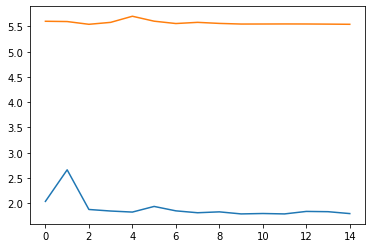

In [ ]:
model = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
device
# Implement the training loop in this cell
if True:
    n_epochs = 15
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    running_loss = 0
    for epoch in range(n_epochs):
        model.train()
        for idx, batch in enumerate(dl_train):
            features, growths = batch
            features, growths = features.to(device), growths.to(device)
            optimizer.zero_grad()
            outputs = model.forward(features.float())
            #loss = F.l1_loss(outputs, growths.float())
            loss = F.mse_loss(outputs, growths.float())
            loss.backward()

            optimizer.step()
            running_loss += loss
            if idx % 2000 == 0:
                print(f"Epoch {epoch}, {int(idx/len(dl_train)*100)}%")
        #if (epoch+1) % 500 == 0:
        train_errors.append(running_loss/len(dl_train))
        val_errors.append(compute_loss(model, dl_val))
        print_progress(epoch, train_errors[-1], val_errors[-1])
        running_loss = 0
        scheduler.step()
            
    plt.plot(torch.stack(train_errors).cpu().detach())
    plt.plot(torch.stack(val_errors).cpu().detach())
    plt.show()
    

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/permnos", "rb") as fp:   # Unpickling
    permnos = pickle.load(fp)
test_df = test_df[test_df['permno'].isin(permnos)]
print(len(test_df))
ds_test_eval = CompanyDatasetMLP(test_df, True)

with torch.no_grad():
      features, tgt = torch.Tensor(ds_test_eval[:][0]).to(device), torch.Tensor(ds_test_eval[:][1]).to(device)
      prices = ds_test_eval[:][2]
      preds = model.forward(features.float())
      tgt_prices = prices['end_price']
      tgt_ish = prices['start_price'] * ((tgt).tolist())
      pred_prices = prices['start_price'] * (preds).tolist()
      r2 = r_squared(pd.Series(preds.cpu()), pd.Series(tgt.cpu()), 1.09783173099033)
      print(f"R2 score of the model: {r2}")

69065
R2 score of the model: 0.037831127643585205


In [ ]:
print(pd.Series(tgt.cpu()).describe())
print(pd.Series(preds.cpu()).describe())
tgt_prices = prices['end_price']
tgt_ish = prices['start_price'] * ((tgt).tolist())
pred_prices = prices['start_price'] * (preds).tolist()

accuracy_level = pd.Series((1 - abs(((tgt)/(preds))-1)).tolist())
test = accuracy_level.sort_values()
print(accuracy_level.describe())
print(accuracy_level.median())


count    69065.000000
mean         1.452936
std          2.688344
min          0.013879
25%          0.794248
50%          1.077978
75%          1.478298
max        209.708267
dtype: float64
count    69065.000000
mean         1.213162
std          0.546183
min         -1.123731
25%          1.040222
50%          1.112596
75%          1.268174
max         56.719357
dtype: float64
count    69065.000000
mean         0.443937
std          1.675162
min       -158.621597
25%          0.439709
50%          0.683164
75%          0.851838
max          0.999980
dtype: float64
0.6831640005111694
